In [1]:
%matplotlib inline   

In [3]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform

import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox, Button
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

from IPython.display import display

import seaborn as sns
sns.set()
sns.set_context("talk")


In [5]:
# Initial values (can be changed by widgets)
n_trials_max = 5000          # maximum number of coin tosses
prob_heads = 0.4             # p_h, the true probability of a heads
x = np.linspace(0, 1, 301)   # mesh for posterior plots (enough so smooth)

class Data():
    """Class to hold the array of heads and tails (1s and 0s) outcomes."""
    def __init__(self, prob_heads=0.5, n_trials_max=5000):
        self._data = self.generate_data(prob_heads, n_trials_max)
        
    def generate_data(self, prob_heads, n_trials_max):
        """Generate an array of heads or tails, 1 or 0, for n_trials_max
           independent tosses according to the Bernoulli distribution."""
        self._data = stats.bernoulli.rvs(prob_heads, size=n_trials_max)
    
    def heads_in_data_to_N(self, N):
        """Count how many heads in the first N elements of the data."""
        return self._data[:N].sum()

coin_data = Data(prob_heads, n_trials_max)    
    
def update_plot(N=0, jump=1, recalculate_data=True, 
                prob_heads=0.5, n_trials_max=5000,
                alpha_1=1., beta_1=1.,
                alpha_2=30., beta_2=30.,
                alpha_3=0.2, beta_3=0.3
               ):
    """
    Make a new plot based on the current widget settings for the input
    parameters.
    """  
    
    font_size = 18
    plt.rcParams.update({'font.size': font_size})
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1, 1, 1)

    if recalculate_data:
        coin_data.generate_data(prob_heads, n_trials_max)
        recalculate_data_w.value = False

    heads = coin_data.heads_in_data_to_N(N)   # add up the 1s (= # of heads)
    # update using the conjugate prior, which is a beta pdf
    y_1 = stats.beta.pdf(x, alpha_1 + heads, beta_1 + N - heads)    
    y_2 = stats.beta.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
    y_3 = stats.beta.pdf(x, alpha_3 + heads, beta_3 + N - heads)   

    # default y_3 distribution has two high max at endpoints for plot
    y_max = np.max([y_1.max(), y_2.max()])  
    
    line1, = ax.plot(x, y_1, label="uniform prior", color="blue")
    ax.fill_between(x, 0, y_1, color="blue", alpha=0.1)
    line2, = ax.plot(x, y_2, label="informative prior", color="red")
    ax.fill_between(x, 0, y_2, color="red", alpha=0.1)
    line3, = ax.plot(x, y_3, label="anti prior", color="green")
    ax.fill_between(x, 0, y_3, color="green", alpha=0.1)
     
    ax.set_xlabel("$p_h$, probability of heads") 
    ax.set_yticks([])  # turn off the plotting of ticks on the y-axis
    ax.axvline(prob_heads, 0, 1.1*y_max, color="k", linestyle="--", lw=2)
    ax.annotate(f'observe {N:d} tosses,\n {heads:d} heads', 
                xy=(0.05,0.85), xycoords='axes fraction', 
                horizontalalignment='left',verticalalignment='top')
    leg = ax.legend(loc='upper right')
    leg.get_frame().set_alpha(0.4)
    ax.autoscale(tight=True)

    
################### begin: text for help tabs ##################
# In HTML (could move this to an external file!)
overview_text = \
   r"""<p>Here we explore Bayesian updating for a coin flip. There is help 
          available under the other tabs.</p>  
          <ul>
            <li>Bayes theorem tab: find out about Bayesian updating.
            <li>Toss coin tab: find out what the controls do.
            <li>Priors tab: change the three initial priors.
            <li>Setup tab: change how the plots are made.
          </ul>      
    """ 
Bayes_text = \
    r"""
    <p>Recall Bayes' theorem with $\thetavec$ the vector of parameters 
    we seek and information $I$ is kept implicit.</p>

    $$
     \newcommand{\thetavec}{\boldsymbol{\theta}}
     \overbrace{p(\thetavec \mid \textrm{data},I)}^{\textrm{posterior}} =
     \frac{\color{red}{\overbrace{p(\textrm{data} 
     \mid \thetavec,I)}^{\textrm{likelihood}}} \times
      \color{blue}{\overbrace{p(\thetavec \mid I)}^{\textrm{prior}}}}
      {\color{darkgreen}{\underbrace{p(\textrm{data} 
         \mid I)}_{\textrm{evidence}}}}
   $$

    <p>If we view the prior as the initial information we have about 
     $\thetavec$, summarized as a probability density function, 
     then Bayes' theorem tells us how to <em>update</em> that 
     information after observing some data: this is the posterior pdf.  
     Here we will look at an example of how this plays out in practice:
     flipping a (biased) coin.</p>     

    <br>

    <p>The idea here is that we are observing successive flips of a coin, 
    which is a proxy for any process that has a binary outcome.  
    There is a definite true probability for getting heads, 
    which we'll label $p_h$, but we don't know what it is.  
    We start with a preconceived notion of the probability expressed 
    in terms of a prior pdf for $p_h$, i.e., $p(p_h)$.  
    With each flip of the coin, we have more information, so our goal is 
    to <em>update</em> our expectation of $p_h$, meaning we want the 
    posterior $p(p_h\mid \mbox{# tosses, # heads})$.</p> 

   """

toss_coin_text = \
    r"""
    The graph shows three posteriors that result from three choices for
    the prior (see the "Priors" tab for details) for the number of coin
    tosses and observed heads shown at the upper left. The true probability
    of a heads, $p_h$, is indicated by a dashed vertical line.
    <ul>
      <li>The "Next" button advances the number of coin tosses by the
        amount shown after "Jump".
      <li>The "Jump" pulldown is used to set how many observations are
       made with each press of the "Next" button.
      <li>The "Reset" button sets the number of observations back to zero.
      <li>The probability of heads $p_h$ can be adjusted between 0 and
      1 using the slider.
    </ul>
    """

setup_text = \
    r"""
    Select the maximum number of trials possible.  The calculations will
    simply stop if you try to go higher.
    """

initial_text = \
    r"""
    The graph shows three posteriors that result from three choices for
    the prior (set under the "Priors" tab) for the number of coin
    tosses and observed heads shown at the upper left. The true probability
    of a heads, $p_h$, is indicated by a dashed vertical line.
    Press "Next" to make observations, "Reset" to go back to zero.
    """
initial_text_w = HTMLMath(value=initial_text)

priors_text = \
    r"""
    Hyperparameters for several different priors (all beta distributions).
    Default prior 1 ($\alpha_1 = 1$, $\beta_1 = 1$) is uniform in [0,1].
    Default prior 2 ($\alpha_2 = 30$, $\beta_2 = 30$) is concentrated 
    near 0.5 with very small tails.
    Defalt prior 3 ($\alpha_3 = .2$, $\beta_3 = .2$) is peaked at the ends, 
    but allows for probability everywhere.
    """
priors_text_w = HTMLMath(value=priors_text)
################### end: text for help tabs ##################
    
    
    
    
################### begin: definitions of widgets ##################
recalculate_data_w = Checkbox(value=True)    
prob_heads_w = FloatSlider(value=prob_heads, min=0., max=1., step=0.05,
                           description=r'true $p_h$:',
                           continuous_update=False)
n_trials_max_w = IntSlider(value=n_trials_max, min=100, max=10000, step=100,
                           description='max # trials:',
                           continuous_update=False)
 
N_w = IntSlider(value=0, min=0, max=n_trials_max, step=1,
                continuous_update=False)
next_button_w = Button(description='Next', disabled=False,
                       layout=Layout(width='80px'), button_style='', 
                       tooltip='Increment number of trials by jump')
reset_button_w = Button(description='Reset', disabled=False,
                        layout=Layout(width='80px'), button_style='', 
                        tooltip='Reset number of trials to zero')

jump_w = Dropdown(description='Jump:',
                  layout=Layout(width='150px'),
                  options=['1', '10', '100', '1000'],
                  value='1',
                  continuos_update=False,
                  disabled=False,)

alpha_1_w = FloatSlider(value=1., min=0., max=2., step=0.1,
                           description=r'$\alpha_1$:',
                           continuous_update=False)
alpha_1_w.style.handle_color = 'blue'

alpha_2_w = FloatSlider(value=30., min=5., max=200., step=5.,
                           description=r'$\alpha_2$:',
                           continuous_update=False)
alpha_2_w.style.handle_color = 'red'
alpha_3_w = FloatSlider(value=0.2, min=0., max=1., step=0.1,
                           description=r'$\alpha_3$:',
                           continuous_update=False)
alpha_3_w.style.handle_color = 'green'
beta_1_w = FloatSlider(value=1., min=0.1, max=2., step=0.1,
                           description=r'$\beta_1$:',
                           continuous_update=False)
beta_1_w.style.handle_color = 'blue'
beta_2_w = FloatSlider(value=30., min=5., max=200., step=5.,
                           description=r'$\beta_2$:',
                           continuous_update=False)
beta_2_w.style.handle_color = 'red'
beta_3_w = FloatSlider(value=0.2, min=0., max=1., step=0.1,
                           description=r'$\beta_3$:',
                           continuous_update=False)
beta_3_w.style.handle_color = 'green'

# Widgets for the help section, which are HTMLMath boxes in a Tab widget
help_overview_w = HTMLMath(value=overview_text)
help_Bayes_w = HTMLMath(value=Bayes_text)
help_toss_coin_w = HTMLMath(value=toss_coin_text)
help_priors_w = HTMLMath(value=priors_text)
help_setup_w = HTMLMath(value=setup_text)

################### end: definitions of widgets ##################

################### begin: explicit widget callbacks ##################
def update_N(b):
    """Increment the number of trials N by the Jump value"""
    N_w.value += int(jump_w.value)
    
def reset_N(b):
    """Reset the number of trials N to zero"""
    N_w.value = 0
    
def update_prob_heads(b):
    """Change the value of prob_heads and regenerate data."""
    recalculate_data_w.value = True
    N_w.max = n_trials_max_w.value

next_button_w.on_click(update_N)
reset_button_w.on_click(reset_N)
 
prob_heads_w.observe(update_prob_heads, 'value')    
n_trials_max_w.observe(update_prob_heads, 'value')    

################### end: explicit widget callbacks ##################


# Organize the help as Tabs (which will be itself under the Help Tab)
help_max_height = '500px'
help_tab = Tab(children=[help_overview_w, help_Bayes_w, help_toss_coin_w, 
                         help_priors_w, help_setup_w], 
               layout=Layout(width='95%', max_height=help_max_height))
help_tab.set_title(0, 'Overview')
help_tab.set_title(1, 'Bayes Theorem')
help_tab.set_title(2, 'Toss Coin')
help_tab.set_title(3, 'Priors')
help_tab.set_title(4, 'Set-up')
    
# Boxes of widgets that will go into the top-level tabs
textbox0 = HBox([initial_text_w])
hbox0 = HBox([next_button_w, jump_w, reset_button_w, prob_heads_w])
textbox1 = HBox([priors_text_w])
hbox1a = HBox([alpha_1_w, alpha_2_w, alpha_3_w])
hbox1b = HBox([beta_1_w, beta_2_w, beta_3_w])
hbox2 = HBox([n_trials_max_w])
hbox3 = HBox([help_tab])

# We'll set up Tabs to organize the controls.  The Tab contents are declared
#  as tab0, tab1, ... (probably should make this a list) and the overall Tab
#  is called tab (so its children are tab0, tab1, ...).
tab_height = '70px'  # Fixed minimum height for all tabs. Specify another way?
tab0 = VBox([textbox0, hbox0], layout=Layout(min_height=tab_height))
tab1 = VBox([textbox1, hbox1a, hbox1b], layout=Layout(min_height=tab_height))
tab2 = VBox([hbox2], layout=Layout(min_height=tab_height))
tab3 = VBox([hbox3], layout=Layout(min_height=tab_height))

tab = Tab(children=[tab0, tab1, tab2, tab3])
tab.set_title(0, 'Toss Coin')
tab.set_title(1, 'Priors')
tab.set_title(2, 'Set-up')
tab.set_title(3, 'Help')

plot_out = widgets.interactive_output(update_plot,
                                      dict(
                                           N=N_w,
                                           jump=jump_w,
                                           recalculate_data=recalculate_data_w,
                                           prob_heads=prob_heads_w,
                                           n_trials_max=n_trials_max_w,
                                           alpha_1=alpha_1_w, beta_1=beta_1_w,
                                           alpha_2=alpha_2_w, beta_2=beta_2_w,
                                           alpha_3=alpha_3_w, beta_3=beta_3_w,
                                      )
                                     )

UI_box = VBox([tab, plot_out])

In [6]:
display(UI_box)   

In [7]:
np.random.seed(999)         # for reproducibility
pH=0.6                       # biased coin
flips=np.random.rand(2**12) # simulates 4096 coin flips
heads=flips<pH              # boolean array, heads[i]=True if flip i is heads


In [8]:
def prior(pH):
    p=np.zeros_like(pH)
    p[(0<=pH)&(pH<=1)]=1      # allowed range: 0<=pH<=1
    return p                # uniform prior
def likelihood(pH,data):
    N = len(data)
    no_of_heads = sum(data)
    no_of_tails = N - no_of_heads
    return pH**no_of_heads * (1-pH)**no_of_tails
def posterior(pH,data):
    p=prior(pH)*likelihood(pH,data)
    norm=np.trapz(p,pH)
    return p/norm

/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return p/norm
/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return p/norm
/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return p/norm
/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return p/norm
/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return p/norm
/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return p/norm
/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return p/norm
/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return p/norm
/tmp/ipykernel_25472/3857809966.py:13: RuntimeWarning: invalid value encountered in true_divide
  return

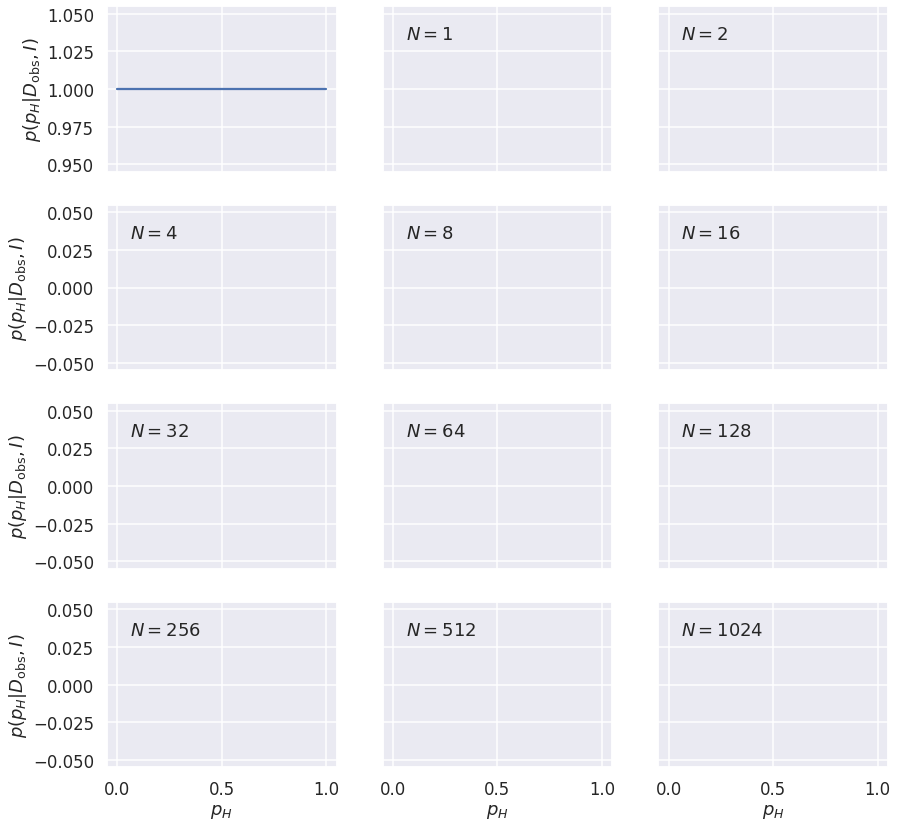

In [14]:
pH=np.linspace(0,1,1000)
fig, axs = plt.subplots(nrows=4,ncols=3,sharex=True,sharey='row',figsize=(14,14))
axs_vec=np.reshape(axs,-1)
axs_vec[0].plot(pH,prior(pH))
for ndouble in range(11):
    ax=axs_vec[1+ndouble]
    ax.plot(pH,posterior(pH,heads[:2000]))
    ax.text(0.1, 0.8, '$N={0}$'.format(2**ndouble), transform=ax.transAxes)
for row in range(4): axs[row,0].set_ylabel('$p(p_H|D_\mathrm{obs},I)$')
for col in range(3): axs[-1,col].set_xlabel('$p_H$')
 

e can then define the autocorrelation function $\rho(h)$ from the list of samples. 
$$
\rho(h) = \frac{\sum_{t=0}^{N-h-1} \left[ (X_t - \bar{X}) (X_{t+h} - \bar{X})\right]}
{\sqrt{ \sum_{t=0}^{N} (X_t - \bar{X})^2 } \sqrt{ \sum_{t=0}^{N-h-1} (X_{t+h} - \bar{X})^2 }}
$$
The summation is carried out over the subset of samples that overlap.